In [10]:
!pip install tpot

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
df = pd.read_csv('train.csv')

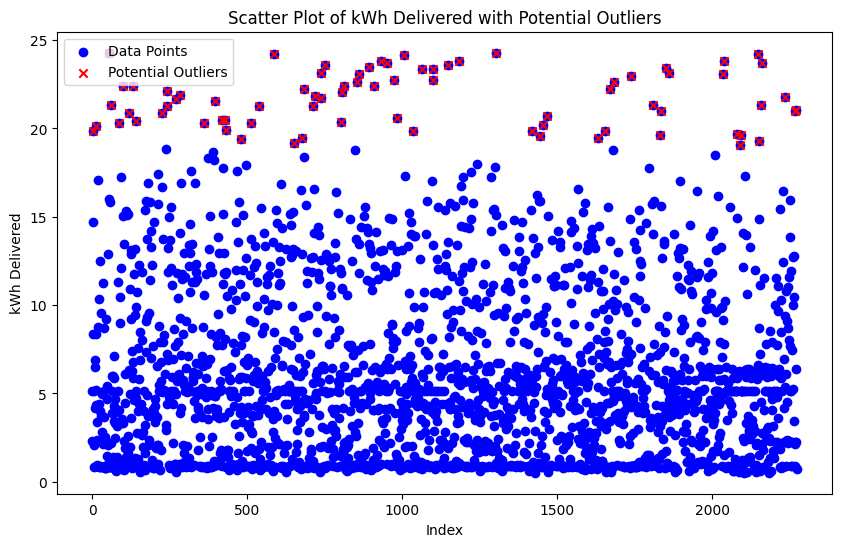

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(df.index, df['kWhDelivered'], color='blue', label='Data Points')

q1 = df['kWhDelivered'].quantile(0.25)
q3 = df['kWhDelivered'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['kWhDelivered'] < lower_bound) | (df['kWhDelivered'] > upper_bound)]
plt.scatter(outliers.index, outliers['kWhDelivered'], color='red', label='Potential Outliers', marker='x')

plt.title('Scatter Plot of kWh Delivered with Potential Outliers')
plt.xlabel('Index')
plt.ylabel('kWh Delivered')
plt.legend()

plt.show()

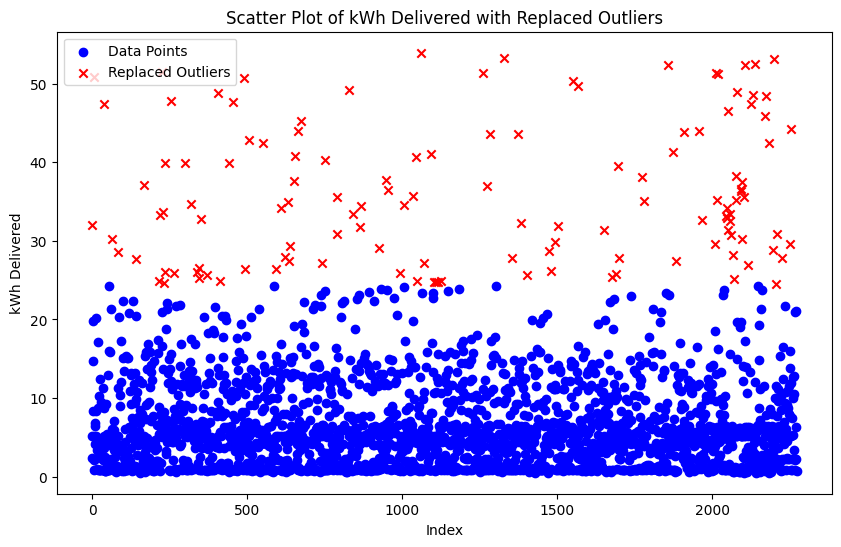

In [18]:
df['kWhDelivered'] = df['kWhDelivered'].apply(lambda x: df['kWhDelivered'].median() if x < lower_bound or x > upper_bound else x)

plt.figure(figsize=(10, 6))

plt.scatter(df.index, df['kWhDelivered'], color='blue', label='Data Points')

plt.scatter(outliers.index, outliers['kWhDelivered'], color='red', label='Replaced Outliers', marker='x')

plt.title('Scatter Plot of kWh Delivered with Replaced Outliers')
plt.xlabel('Index')
plt.ylabel('kWh Delivered')
plt.legend()

plt.show()


In [19]:
##New implementation

# Convert string columns to datetime
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])

df = df[['connectionTime', 'disconnectTime', 'kWhDelivered']]

hourly_df = pd.DataFrame(columns=['time', 'kWhDelivered'])

for index, row in df.iterrows():
    connection_time = row['connectionTime']
    disconnect_time = row['disconnectTime']
    total_kwh_delivered = row['kWhDelivered']

    energy_per_sec = total_kwh_delivered/(disconnect_time - connection_time).total_seconds()

    current_time = connection_time

    while current_time <= disconnect_time:


        ######################################################

        if connection_time.ceil('h') == disconnect_time.ceil('h'):
            hourly_df = pd.concat([hourly_df, pd.DataFrame({'time': [connection_time.floor('h')], 'kWhDelivered': [total_kwh_delivered]})], ignore_index=True)
            break

        if current_time == connection_time and connection_time != connection_time.ceil('h'):
            kwh_delivered_hourly = ((current_time.ceil('h') - connection_time).total_seconds())*energy_per_sec
            hourly_df = pd.concat([hourly_df, pd.DataFrame({'time': [current_time.floor('h')], 'kWhDelivered': [kwh_delivered_hourly]})], ignore_index=True)
            current_time = current_time.ceil('h')
        elif current_time + pd.Timedelta(hours=1) >= disconnect_time:
            kwh_delivered_hourly = ((disconnect_time - current_time).total_seconds())*energy_per_sec
            hourly_df = pd.concat([hourly_df, pd.DataFrame({'time': [current_time], 'kWhDelivered': [kwh_delivered_hourly]})], ignore_index=True)
            break
        else:
            kwh_delivered_hourly = 3600*energy_per_sec
            hourly_df = pd.concat([hourly_df, pd.DataFrame({'time': [current_time], 'kWhDelivered': [kwh_delivered_hourly]})], ignore_index=True)
            current_time += pd.Timedelta(hours=1)

        ######################################################


# Convert time column to datetime type
hourly_df['time'] = pd.to_datetime(hourly_df['time'])

hourly_df.head()


,time,kWhDelivered
0,2020-01-01 09:00:00+00:00,0.091221
1,2020-01-01 10:00:00+00:00,0.308062
2,2020-01-01 11:00:00+00:00,0.308062
3,2020-01-01 12:00:00+00:00,0.308062
4,2020-01-01 13:00:00+00:00,0.308062


In [20]:
hourly_df = hourly_df.groupby('time').agg('sum').reset_index()

In [21]:
#fill the missing time stamps

# data = {
#     'time': ['2020-01-01 09:00:00', '2020-01-01 10:00:00', '2020-01-01 12:00:00', '2020-01-01 13:00:00'],
#     'kWhDelivered': [0.566942, 1.914626, 1.914626, 1.914626]
# }

# df = pd.DataFrame(data)

# Convert 'time' column to datetime type
hourly_df['time'] = pd.to_datetime(hourly_df['time'])

# Set 'time' column as index
hourly_df.set_index('time', inplace=True)

start_date = hourly_df.index.min().floor('D')
end_date = hourly_df.index.max().ceil('D')
complete_index = pd.date_range(start=start_date, end=end_date, freq='h')
complete_df = pd.DataFrame(index=complete_index)

final_hourly_df = complete_df.merge(hourly_df, how='left', left_index=True, right_index=True)
final_hourly_df['kWhDelivered'].fillna(0, inplace=True)

# Reset index to have 'time' as a column again
final_hourly_df.reset_index(inplace=True)
final_hourly_df.rename(columns={'index': 'time'}, inplace=True)

final_hourly_df[:-1].head()

,time,kWhDelivered
0,2020-01-01 00:00:00+00:00,0.0
1,2020-01-01 01:00:00+00:00,0.0
2,2020-01-01 02:00:00+00:00,0.0
3,2020-01-01 03:00:00+00:00,0.0
4,2020-01-01 04:00:00+00:00,0.0


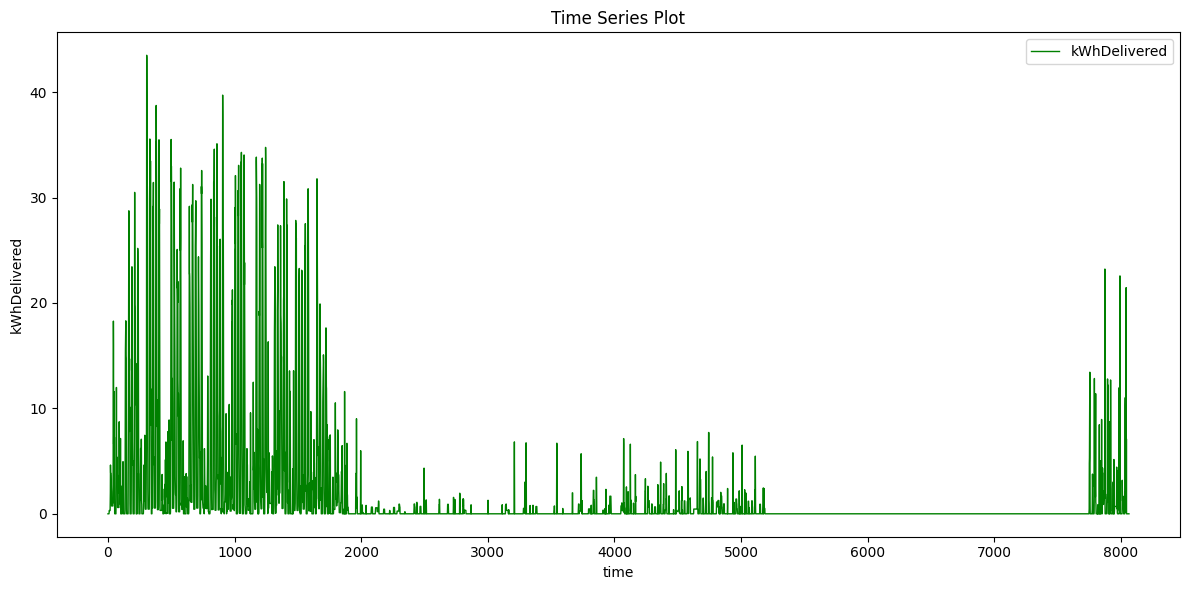

In [22]:
import matplotlib.pyplot as plt

# final_hourly_df.index = pd.to_datetime(final_hourly_df['time'])

plt.figure(figsize=(12, 6))
plt.plot(final_hourly_df.index, final_hourly_df['kWhDelivered'], label='kWhDelivered', color='g', linewidth=1)
plt.xlabel('time')
plt.ylabel('kWhDelivered')
plt.title('Time Series Plot')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
final_hourly_df['date'] = final_hourly_df['time'].dt.date
final_hourly_df['hour'] = final_hourly_df['time'].dt.hour
final_hourly_df['day_of_week'] = final_hourly_df['time'].dt.dayofweek
final_hourly_df['day_of_year'] = final_hourly_df['time'].dt.dayofyear
final_hourly_df['day_of_month'] = final_hourly_df['time'].dt.day
final_hourly_df['month'] = final_hourly_df['time'].dt.month
final_hourly_df['quarter'] = final_hourly_df['time'].dt.quarter
final_hourly_df['year'] = final_hourly_df['time'].dt.year

final_hourly_df.head()

,time,kWhDelivered,date,hour,day_of_week,day_of_year,day_of_month,month,quarter,year
0,2020-01-01 00:00:00+00:00,0.0,2020-01-01,0,2,1,1,1,1,2020
1,2020-01-01 01:00:00+00:00,0.0,2020-01-01,1,2,1,1,1,1,2020
2,2020-01-01 02:00:00+00:00,0.0,2020-01-01,2,2,1,1,1,1,2020
3,2020-01-01 03:00:00+00:00,0.0,2020-01-01,3,2,1,1,1,1,2020
4,2020-01-01 04:00:00+00:00,0.0,2020-01-01,4,2,1,1,1,1,2020


In [9]:
final_hourly_df.columns

Index(['time', 'kWhDelivered', 'date', 'hour', 'day_of_week', 'day_of_year',
       'day_of_month', 'month', 'quarter', 'year'],
      dtype='object')

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = final_hourly_df[['hour', 'day_of_week', 'day_of_year',
       'day_of_month', 'month', 'quarter', 'year']]
y = final_hourly_df['kWhDelivered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)


Mean Squared Error: 25.157490313705875


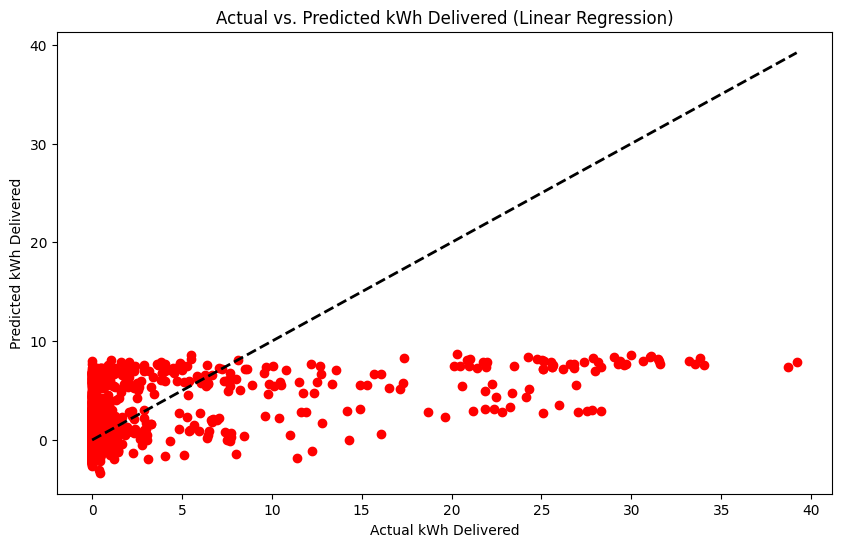

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', lw=2)
plt.xlabel('Actual kWh Delivered')
plt.ylabel('Predicted kWh Delivered')
plt.title('Actual vs. Predicted kWh Delivered (Linear Regression)')
plt.show()

In [26]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = final_hourly_df[['hour', 'day_of_week', 'day_of_year', 'day_of_month', 'month', 'quarter', 'year']]
y = final_hourly_df['kWhDelivered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)


params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'early_stopping_rounds': 10
    }

model = lgb.train(params,
                   train_data,
                   num_boost_round=100,
                   valid_sets=[test_data],
                   )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 3.1245868796532457


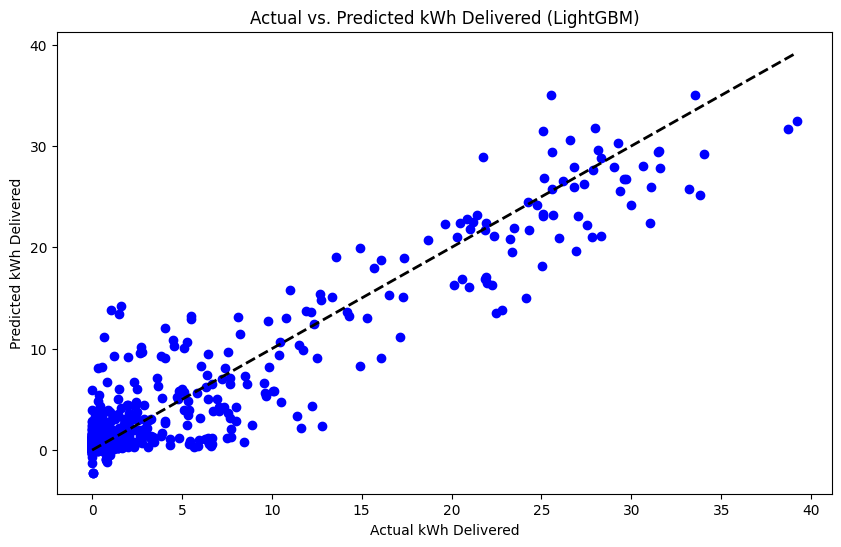

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', lw=2)
plt.xlabel('Actual kWh Delivered')
plt.ylabel('Predicted kWh Delivered')
plt.title('Actual vs. Predicted kWh Delivered (LightGBM)')
plt.show()


In [28]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = final_hourly_df[['hour', 'day_of_week', 'day_of_year', 'day_of_month', 'month', 'quarter', 'year']]
y = final_hourly_df['kWhDelivered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tpot = TPOTRegressor(generations=15, population_size=20, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

y_pred = tpot.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

tpot.export('tpot_pipeline.py')


Optimization Progress:   0%|          | 0/320 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.9737173837082436

Generation 2 - Current best internal CV score: -2.9737173837082436

Generation 3 - Current best internal CV score: -2.947227498142659

Generation 4 - Current best internal CV score: -2.947227498142659

Generation 5 - Current best internal CV score: -2.58199696531062

Generation 6 - Current best internal CV score: -2.58199696531062

Generation 7 - Current best internal CV score: -2.58199696531062

Generation 8 - Current best internal CV score: -2.58199696531062

Generation 9 - Current best internal CV score: -2.58199696531062

Generation 10 - Current best internal CV score: -2.58199696531062

Generation 11 - Current best internal CV score: -2.4948981745914187

Generation 12 - Current best internal CV score: -2.4948981745914187

Generation 13 - Current best internal CV score: -2.4948981745914187

Generation 14 - Current best internal CV score: -2.4224291689678803

Generation 15 - Current best internal CV score: -2.42242

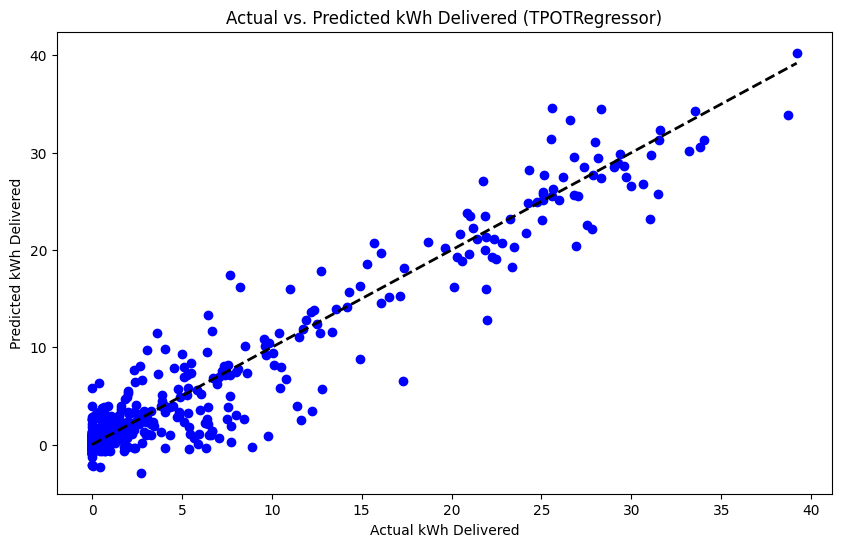

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', lw=2)
plt.xlabel('Actual kWh Delivered')
plt.ylabel('Predicted kWh Delivered')
plt.title('Actual vs. Predicted kWh Delivered (TPOTRegressor)')
plt.show()


In [34]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd


X_train = final_hourly_df[['hour', 'day_of_week', 'day_of_year', 'day_of_month', 'month', 'quarter', 'year']]
y_train = final_hourly_df['kWhDelivered']

tpot = TPOTRegressor(generations=15, population_size=20, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

date_range = pd.date_range(start='2020-12-01 12:00:00', end='2021-01-01 12:00:00', freq='H')
X_pred = pd.DataFrame({
    'hour': date_range.hour,
    'day_of_week': date_range.dayofweek,
    'day_of_year': date_range.dayofyear,
    'day_of_month': date_range.day,
    'month': date_range.month,
    'quarter': date_range.quarter,
    'year': date_range.year
})

X_pred.columns = X_train.columns

y_pred = tpot.predict(X_pred)

submission_df = pd.DataFrame({
    'Id': range(1, len(y_pred) + 1),
    'Predicted': y_pred
})

submission_df.to_csv('submission.csv', index=False)


Optimization Progress:   0%|          | 0/320 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -13.560439933649814

Generation 2 - Current best internal CV score: -11.807551654896542

Generation 3 - Current best internal CV score: -11.807551654896542

Generation 4 - Current best internal CV score: -11.807551654896542

Generation 5 - Current best internal CV score: -11.807551654896542

Generation 6 - Current best internal CV score: -11.807551654896542

Generation 7 - Current best internal CV score: -11.708926957074468

Generation 8 - Current best internal CV score: -11.708926957074468

Generation 9 - Current best internal CV score: -11.620378505267782

Generation 10 - Current best internal CV score: -11.238986390090746

Generation 11 - Current best internal CV score: -11.238986390090746

Generation 12 - Current best internal CV score: -11.238986390090746

Generation 13 - Current best internal CV score: -11.238986390090746

Generation 14 - Current best internal CV score: -11.238986390090746

Generation 15 - Current best internal CV s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [35]:
submission_df = submission_df.drop(submission_df.index[-1])
submission_df = submission_df.rename(columns={'Id': 'Row ID'})

# Save the modified submission file
submission_df.to_csv('submission.csv', index=False)

In [47]:
actual_df = pd.DataFrame({
    'Id': range(1 , len(final_hourly_df['kWhDelivered'])+1),
    'Predicted': final_hourly_df['kWhDelivered']
})
actual_df.head()

,Id,Predicted
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [50]:
predicted_df_to_plot = pd.DataFrame({
    'Id': range(len(final_hourly_df['kWhDelivered'])+1, len(final_hourly_df['kWhDelivered'])+1+len(y_pred)),
    'Predicted': y_pred
})
predicted_df_to_plot.head()

,Id,Predicted
0,8066,0.000075
1,8067,0.000075
2,8068,0.000075
3,8069,0.000075
4,8070,0.296549


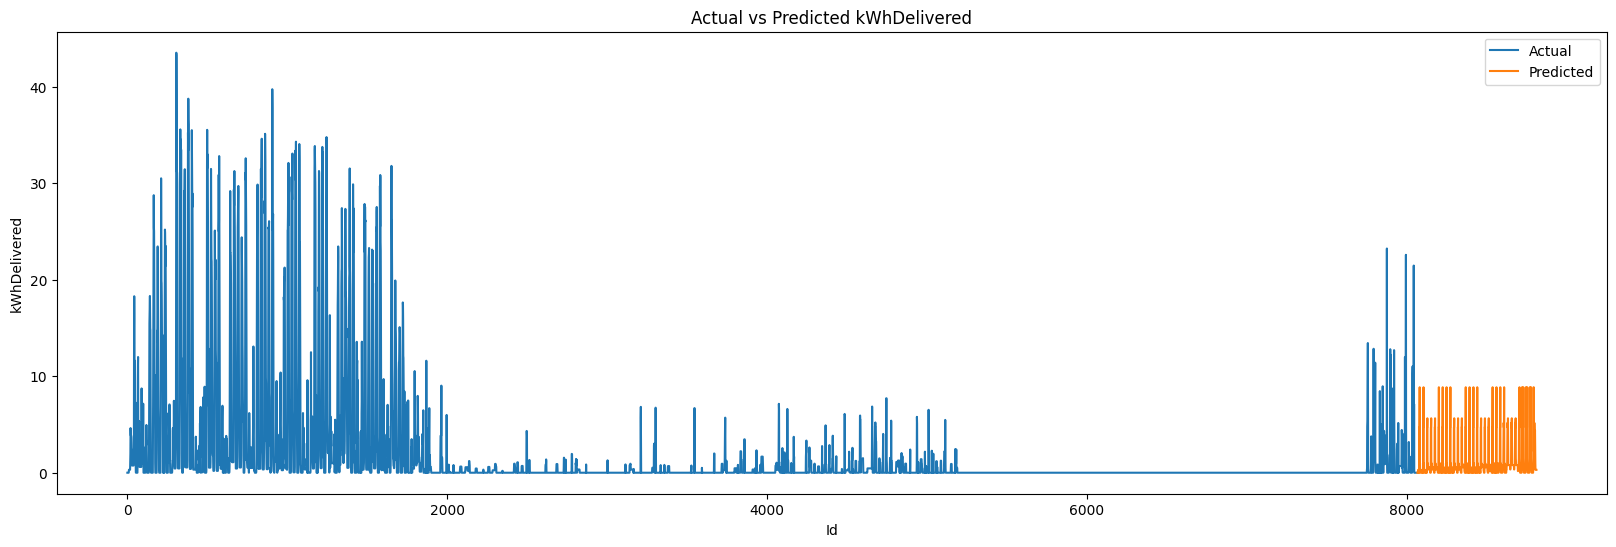

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(actual_df['Id'], actual_df['Predicted'], label='Actual')

plt.plot(predicted_df_to_plot['Id'], predicted_df_to_plot['Predicted'], label='Predicted')

plt.xlabel('Id')
plt.ylabel('kWhDelivered')
plt.title('Actual vs Predicted kWhDelivered')
plt.legend()

plt.show()